In [222]:
import numpy as np
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

## Generate fake

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def normalize(x):
    x_min = x.min()
    x_max = x.max()
    
    x = (x-x_min)/(x_max -x_min)
    return x

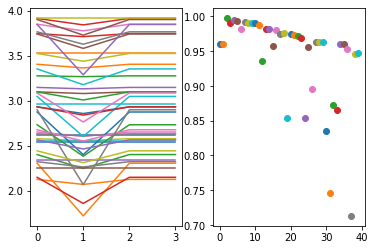

In [192]:
time_steps = 40
n_cells = 4 # Amount of cells in pack
x = np.zeros([time_steps,n_cells])


fig, ax = plt.subplots(1,2)

failed_cell = 1 # Which cell is the failing cell
is_fail = True# Does the pack include a failed cell
volt_stochastic = 0.9
for i in range(time_steps):
    sigma = 0.0 # How much is the fluctuation
    median = random.uniform(2, 4)
    volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
    if is_fail:
        r = random.random()
        if r < volt_stochastic:
            stochstic_amplifier = random.randint(100,1000)
            
            y = (1-i/stochstic_amplifier)
            #print(y)
            volt[failed_cell]*=y
    ax[1].scatter(i,y)
    x[i,:] = volt
            
    ax[0].plot(volt, label=i)
#plt.ylim(0,16)
#plt.legend()

In [193]:
def create_sequence(time_steps=40, n_cells=4, failed_cell=1, is_fail=True, sigma=0.0, volt_stochastic = 0.9, normalize_x=False):
    x = np.zeros([time_steps,n_cells])
    for i in range(time_steps):
        median = random.uniform(2, 4)
        volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
        if is_fail:
            r = random.random()
            if r < volt_stochastic:
                stochstic_amplifier = random.randint(100,1000)

                y = (1-i/stochstic_amplifier)
                #print(y)
                volt[failed_cell]*=y
        x[i,:] = volt
    if normalize_x:
        x = normalize(x)
    if is_fail:
        label = 1
    else:
        label = 0
    return x, label
    

In [202]:
x,y = create_sequence(time_steps=6, n_cells=4, failed_cell=1, is_fail=True, sigma=0.0, volt_stochastic = 0.9, normalize_x=True)

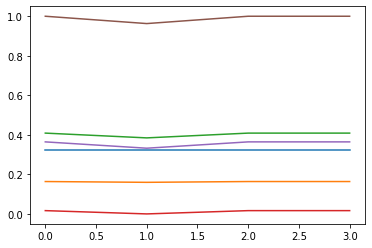

In [203]:
plt.plot(x.T)
plt.show()

In [217]:
def creata_data(n_healthy=2, n_fails=2):
    data = []
    for i in range(n_healthy+n_fails):
        if i >= n_healthy:
            fail=True
        else:
            fail=False
        x,y = create_sequence(time_steps=6, n_cells=4, failed_cell=1, is_fail=fail, sigma=0.0, volt_stochastic = 0.9, normalize_x=False)
        data.append((x,y))
    return data
    

In [218]:
data = creata_data(n_healthy=2, n_fails=2)

In [219]:
data[0][0]

array([[3.1361917 , 3.1361917 , 3.1361917 , 3.1361917 ],
       [2.29428184, 2.29428184, 2.29428184, 2.29428184],
       [2.81179859, 2.81179859, 2.81179859, 2.81179859],
       [2.68159584, 2.68159584, 2.68159584, 2.68159584],
       [3.32812093, 3.32812093, 3.32812093, 3.32812093],
       [3.55444669, 3.55444669, 3.55444669, 3.55444669]])

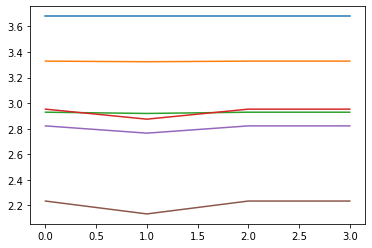

In [223]:
plt.plot(data[2][0].T)

In [224]:
data[0][0].toTensor()

AttributeError: 'numpy.ndarray' object has no attribute 'toTensor'